Keystroke Dynamics Authentication - Ensemble Voting Classifier

Import Library

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

/home/crystallizer/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Set seaborn style
sns.set(style="whitegrid")

Load and Display Data

In [3]:
df = pd.read_csv('./../Dataset/StrongPassword.csv')
df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


Feature Extraction Functions

In [4]:
def get_feature_columns(df):
    """
    Extract column names for dwell times, latency, and flight times.
    """
    dwell_columns = [col for col in df.columns if col.startswith('H.')]
    latency_columns = [col for col in df.columns if col.startswith('DD.')]
    flight_columns = [col for col in df.columns if col.startswith('UD.')]
    return dwell_columns, latency_columns, flight_columns

def extract_features(df, feature_set):
    """
    Extract features based on the specified feature set:
    - 'first_order'
    - 'second_order'
    - 'combined'
    """
    dwell_columns, latency_columns, flight_columns = get_feature_columns(df)

    # First-order features
    first_order_features = pd.concat([
        df[dwell_columns],
        df[latency_columns],
        df[flight_columns]
    ], axis=1)

    if feature_set == 'first_order':
        return first_order_features
    elif feature_set == 'second_order':
        second_order_df = extract_second_order_features(
            first_order_features, dwell_columns, latency_columns, flight_columns
        )
        return second_order_df
    elif feature_set == 'combined':
        second_order_df = extract_second_order_features(
            first_order_features, dwell_columns, latency_columns, flight_columns
        )
        combined_features = pd.concat([first_order_features, second_order_df], axis=1)
        return combined_features
    else:
        raise ValueError("Invalid feature set specified. Choose from 'first_order', 'second_order', or 'combined'.")

def extract_second_order_features(first_order_df, dwell_columns, latency_columns, flight_columns):
    """
    Calculate second-order features including min, max, mean, std, and slope.
    """
    # Mean and Standard Deviation
    second_order_features = {
        'mean_dwell_time': first_order_df[dwell_columns].mean(axis=1),
        'std_dwell_time': first_order_df[dwell_columns].std(axis=1),
        'mean_latency': first_order_df[latency_columns].mean(axis=1),
        'std_latency': first_order_df[latency_columns].std(axis=1),
        'mean_flight_time': first_order_df[flight_columns].mean(axis=1),
        'std_flight_time': first_order_df[flight_columns].std(axis=1),
    }

    # Minimum and Maximum Values
    second_order_features.update({
        'min_dwell_time': first_order_df[dwell_columns].min(axis=1),
        'max_dwell_time': first_order_df[dwell_columns].max(axis=1),
        'min_latency': first_order_df[latency_columns].min(axis=1),
        'max_latency': first_order_df[latency_columns].max(axis=1),
        'min_flight_time': first_order_df[flight_columns].min(axis=1),
        'max_flight_time': first_order_df[flight_columns].max(axis=1),
    })

    # Slope Features
    # Compute difference between consecutive elements in each row
    dwell_slopes = first_order_df[dwell_columns].diff(axis=1).iloc[:, 1:]
    latency_slopes = first_order_df[latency_columns].diff(axis=1).iloc[:, 1:]
    flight_slopes = first_order_df[flight_columns].diff(axis=1).iloc[:, 1:]

    second_order_features.update({
        'mean_dwell_slope': dwell_slopes.mean(axis=1),
        'std_dwell_slope': dwell_slopes.std(axis=1),
        'mean_latency_slope': latency_slopes.mean(axis=1),
        'std_latency_slope': latency_slopes.std(axis=1),
        'mean_flight_slope': flight_slopes.mean(axis=1),
        'std_flight_slope': flight_slopes.std(axis=1),
    })

    second_order_df = pd.DataFrame(second_order_features)
    return second_order_df

Define Model Training and Evaluation Function with Hybrid Sampling

In [5]:
def train_and_evaluate_user(user, df, feature_set, feature_set_name):
    """
    Train and evaluate an Ensemble Voting Classifier (XGBoost, Random Forest, SVM)
    for a specific user using the specified feature set.
    
    Steps:
    - Create binary labels (1: genuine user, 0: imposters)
    - Extract features
    - Undersample imposters
    - Train-test split
    - SMOTE on training data only
    - For SVM: scale features after SMOTE
    - Fit a voting classifier with XGBoost, Random Forest, SVM (soft voting)
    - Compute metrics
    
    Returns: accuracy, precision, recall, f1, training_time, and also return y_test, y_pred for visualization.
    """
    start_time = time.time()

    # Create binary labels
    user_df = df.copy()
    user_df['label'] = (user_df['subject'] == user).astype(int)

    # Extract features
    X = extract_features(user_df, feature_set)
    y = user_df['label']

    # Separate genuine and imposter samples
    genuine = user_df[user_df['label'] == 1]
    imposters = user_df[user_df['label'] == 0]

    X_genuine = X.loc[genuine.index]
    y_genuine = y.loc[genuine.index]
    X_imposters = X.loc[imposters.index]
    y_imposters = y.loc[imposters.index]

    # Undersample imposters
    n_imposter_samples = len(genuine) * 5  # Adjust as needed
    imposters_downsampled_X, imposters_downsampled_y = resample(
        X_imposters,
        y_imposters,
        replace=False,
        n_samples=n_imposter_samples,
        random_state=42,
        stratify=y_imposters
    )

    # Combine genuine with undersampled imposters
    X_combined = pd.concat([X_genuine, imposters_downsampled_X])
    y_combined = pd.concat([y_genuine, imposters_downsampled_y])

    # Train-test split before oversampling
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
    )

    # Apply SMOTE on training data only
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Scale features (important for SVM)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # Initialize individual models
    xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    svm_model = SVC(kernel='rbf', probability=True, random_state=42)

    # Create a VotingClassifier with soft voting
    ensemble_model = VotingClassifier(
        estimators=[('xgb', xgb_model), ('rf', rf_model), ('svm', svm_model)],
        voting='soft'
    )

    # Train the model
    ensemble_model.fit(X_train_scaled, y_train_resampled)

    # Make predictions
    y_pred = ensemble_model.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time

    print(f"Metrics for user {user} using {feature_set_name} (Ensemble):")
    print(f" - Accuracy: {accuracy * 100:.2f}%")
    print(f" - Precision: {precision:.2f}")
    print(f" - Recall: {recall:.2f}")
    print(f" - F1-Score: {f1:.2f}")
    print(f" - Training time: {training_time:.2f} seconds\n")

    return accuracy, precision, recall, f1, training_time, y_test, y_pred

Train Models and Evaluate Performance for All Users and Feature Sets

In [ ]:
users = df['subject'].unique()

feature_sets = {
    'First-Order Features': 'first_order',
    'Second-Order Features': 'second_order',
    'Combined Features': 'combined'
}

# We will store metrics and predictions for plotting
all_results = {}

for feature_set_name, feature_set_key in feature_sets.items():
    print(f"\n=== Training Ensemble models using {feature_set_name} ===\n")

    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    training_times = []

    # We'll also store the last user's confusion matrix info for demonstration
    last_user_y_test = None
    last_user_y_pred = None

    for user in users:
        accuracy, precision, recall, f1, training_time, y_test, y_pred = train_and_evaluate_user(
            user, df, feature_set_key, feature_set_name
        )
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        training_times.append(training_time)

        # Save last user's data
        last_user_y_test = y_test
        last_user_y_pred = y_pred

    # Compute average metrics
    average_accuracy = np.mean(accuracies)
    average_precision = np.mean(precisions)
    average_recall = np.mean(recalls)
    average_f1_score = np.mean(f1_scores)
    average_training_time = np.mean(training_times)

    print(f"Average Metrics Across All Users for {feature_set_name}:")
    print(f" - Average Accuracy: {average_accuracy * 100:.2f}%")
    print(f" - Average Precision: {average_precision:.2f}")
    print(f" - Average Recall: {average_recall:.2f}")
    print(f" - Average F1-Score: {average_f1_score:.2f}")
    print(f" - Average Training Time per User: {average_training_time:.2f} seconds\n")

    all_results[feature_set_name] = {
        'accuracy': average_accuracy,
        'precision': average_precision,
        'recall': average_recall,
        'f1': average_f1_score,
        'training_time': average_training_time,
        'last_user_y_test': last_user_y_test,
        'last_user_y_pred': last_user_y_pred
    }


=== Training Ensemble models using First-Order Features ===

Metrics for user s002 using First-Order Features (Ensemble):
 - Accuracy: 98.33%
 - Precision: 0.94
 - Recall: 0.96
 - F1-Score: 0.95
 - Training time: 3.21 seconds

Metrics for user s003 using First-Order Features (Ensemble):
 - Accuracy: 98.54%
 - Precision: 0.94
 - Recall: 0.97
 - F1-Score: 0.96
 - Training time: 1.98 seconds

Metrics for user s004 using First-Order Features (Ensemble):
 - Accuracy: 98.75%
 - Precision: 0.96
 - Recall: 0.96
 - F1-Score: 0.96
 - Training time: 2.10 seconds

Metrics for user s005 using First-Order Features (Ensemble):
 - Accuracy: 98.96%
 - Precision: 0.97
 - Recall: 0.96
 - F1-Score: 0.97
 - Training time: 1.91 seconds

Metrics for user s007 using First-Order Features (Ensemble):
 - Accuracy: 96.88%
 - Precision: 0.89
 - Recall: 0.93
 - F1-Score: 0.91
 - Training time: 2.55 seconds

Metrics for user s008 using First-Order Features (Ensemble):
 - Accuracy: 96.46%
 - Precision: 0.86
 - Recal

Visualization

1. Confusion Matrix untuk user terakhir pada feature set terakhir.
2. Bar plot untuk membandingkan metrik (accuracy, precision, recall, f1) antar feature set.


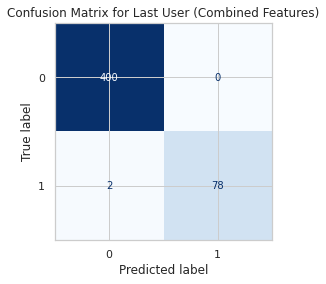

In [ ]:
last_feature_set = list(all_results.keys())[-1]
y_test = all_results[last_feature_set]['last_user_y_test']
y_pred = all_results[last_feature_set]['last_user_y_pred']

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', colorbar=False)
plt.title(f'Confusion Matrix for Last User ({last_feature_set})')
plt.show()

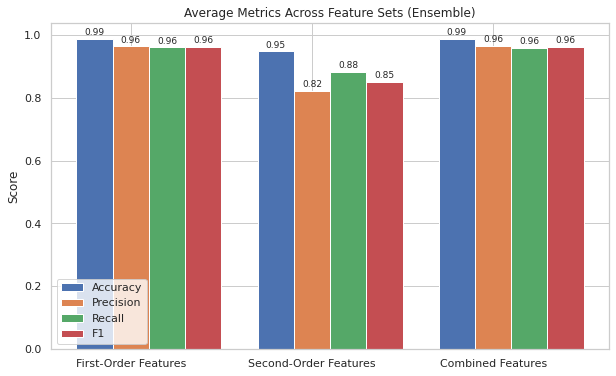

In [8]:
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
feature_set_names = list(all_results.keys())
values = {m: [all_results[fs][m] for fs in feature_set_names] for m in metrics_to_plot}

x = np.arange(len(feature_set_names))  # the label locations
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))

# Plot each metric as a separate set of bars
for i, metric in enumerate(metrics_to_plot):
    ax.bar(x + i*width - width, values[metric], width, label=metric.capitalize())

ax.set_xticks(x)
ax.set_xticklabels(feature_set_names, rotation=0)
ax.set_ylabel('Score')
ax.set_title('Average Metrics Across Feature Sets (Ensemble)')
ax.legend()

for i, metric in enumerate(metrics_to_plot):
    for j, val in enumerate(values[metric]):
        ax.text(j + i*width - width, val + 0.005, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

plt.show()